# LSTM Time Series - Stock Price Prediction
## Part 3 - Model Training
In this notebook, we load the scaled data set files, convert them to format compatible with LSTM model and then train the model.

> **INPUT**: The SCALED data set files for training, validation, and testing periods as processed in the previous phase. <br/>
> **OUTPUT**: The trained LSTM model and analysis of its performance.

### 1. INITIALIZATION

In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

### 2. LOADING DATASETS

In [2]:
# Prepare data file location and name
data_file_location = "..//data//processed//"
data_file_name_train = "google_stock_price_processed_train"
data_file_name_validate = "google_stock_price_processed_validate"
data_file_name_test = "google_stock_price_processed_test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [3]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1217, 7)
Validation Dataset Shape: (62, 7)
Testing Dataset Shape: (20, 7)


In [4]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.000000  0.002422  0.001096  0.014909   0.014909  0.202348  2019-01-02
1  0.012090  0.004758  0.000269  0.000000   0.000000  0.254991  2019-01-03
2  0.007928  0.011707  0.006996  0.027351   0.027351  0.298130  2019-01-04
3  0.027184  0.013291  0.020776  0.026190   0.026190  0.279018  2019-01-07
4  0.029465  0.018586  0.023684  0.030138   0.030138  0.241988  2019-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.737482  0.755729  0.748389  0.768392   0.768392  0.167235  2023-11-01
1  0.779250  0.779294  0.780492  0.778502   0.778502  0.146375  2023-11-02
2  0.774598  0.785712  0.789564  0.796419   0.796419  0.107350  2023-11-03
3  0.785782  0.794035  0.798837  0.807229   0.807229  0.071878  2023-11-06
4  0.803202  0.811282  0.811034  0.816738   0.816738  0.104841  2023-11-07
Testing Dataset:
       Open      High       Low     Close  Ad

### 3. CONSTRUCTING DATA STRUCTURE

Since we are dealing with a time series problem with multiple predictors, we need to construct the input data and reshape it to fit into the LSTM model.

This requires specifying a sliding time window (sequence size) that defines the total number of previous observations to predict the next value.

In this experiment, we consider a sequence of prior samples (financial days) to predict the opening price in the next day.

In [5]:
# Extract dates and features from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

# Extract features into numpy array
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [6]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).
    
    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.
    
    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """
    
    # Initialize constructed data variables
    data_X = []
    data_y = []
    
    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])
        
    # Return constructed variables
    return np.array(data_X), np.array(data_y)

The construction function is currently available for constructing subsets for training, validation, and testing date that is aligned with the LSTM model input.

In [7]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [8]:
# Combine scaled datasets together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate each data length
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [9]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1299, 6)

 Data Train Scaled: (1217, 6)
> Data Train X: (1157, 60, 6)
> Data Train y: (1157,)

 Data Validate Scaled: (62, 6)
> Data Validate X: (62, 60, 6)
> Data Validate y: (62,)

 Data Test Scaled: (20, 6)
> Data Test X: (20, 60, 6)
> Data Test y: (20,)


### 4. BUILDING LSTM MODEL

In [10]:
# Initializing the model
regressor = Sequential()

In [11]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [12]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [13]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [14]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [15]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate = 0.2))

In [16]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [17]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [18]:
# Training the model
history = regressor.fit(x = X_train, y = y_train, validation_data=(X_validate, y_validate), epochs=200, batch_size = 32)

Epoch 1/200


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0846 - val_loss: 0.0028
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0082 - val_loss: 0.0032
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0062 - val_loss: 0.0025
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 8/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 9/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 10/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 11/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 12/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

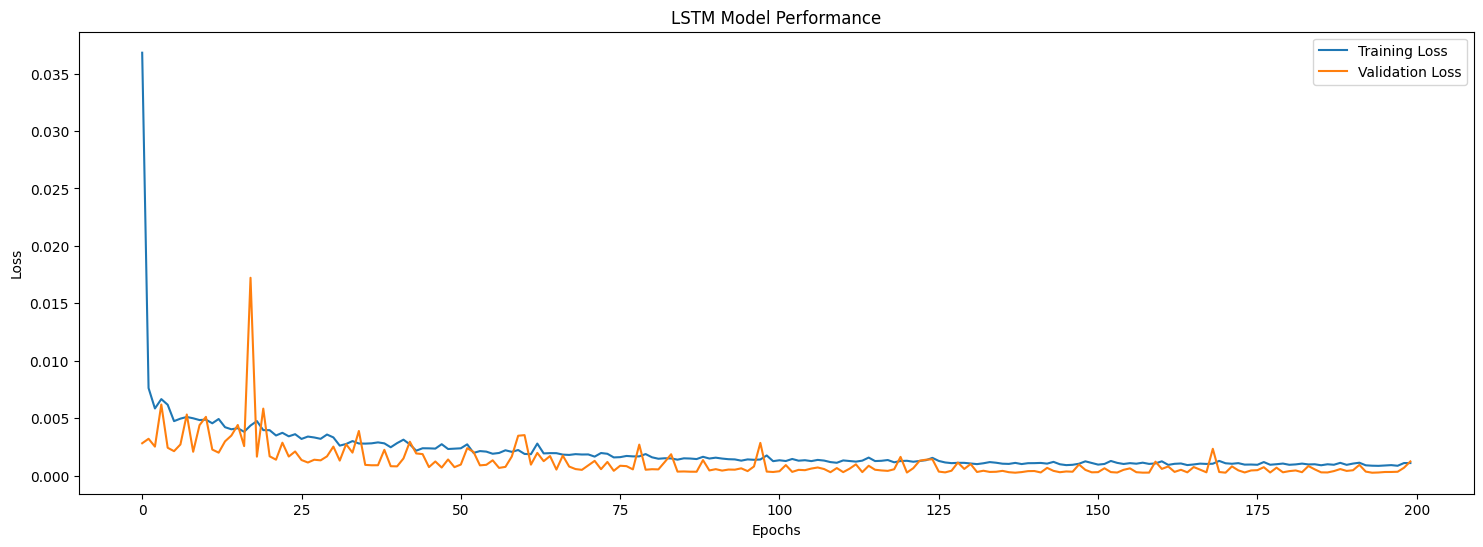

In [19]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
